In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def bumpchart(df, ax=None, scatter=False, line_args={}, scatter_args={}):
    # Adopted from https://github.com/kartikay-bagla/bump-plot-python

    if ax is None:
        left_yaxis = plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()

    axes = [left_yaxis, right_yaxis]

    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha=0)

        left_yaxis.plot(x, y, label=col, **line_args, solid_capstyle="round")

        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]

    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))

    return axes


In [3]:
xlsx = pd.ExcelFile('raw.xlsx')
sheets = dict()
for sheet_name in xlsx.sheet_names:
    original = pd.read_excel(xlsx, sheet_name=sheet_name, header=0, index_col=0)
    ranks = original.rank(axis=1, method='min', ascending=False).astype(int)
    reindexed = ranks.reindex(['xFinder-llama38-it', 'xFinder-qwen1505', 'LM Eval Harness', 'OpenCompass', 'UltraEval'])
    sheets[sheet_name] = reindexed
xlsx.close()

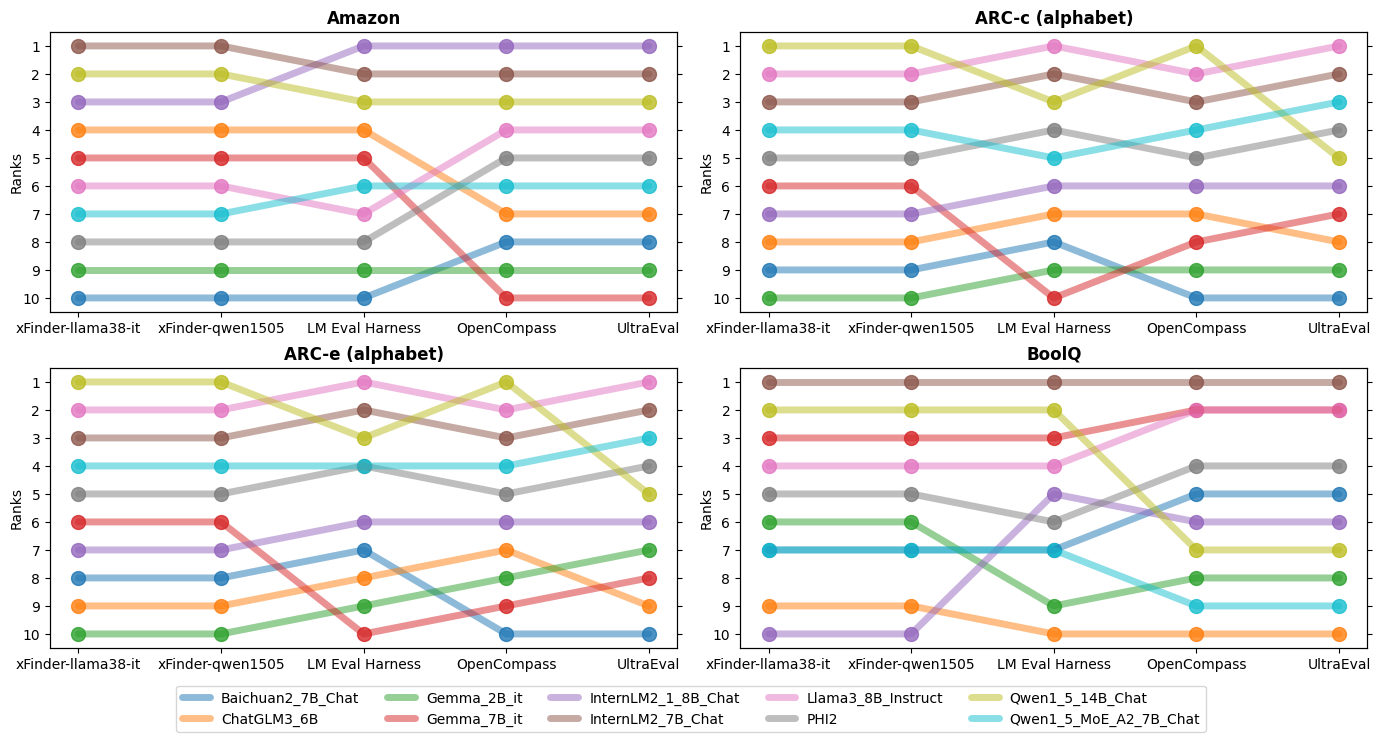

In [4]:
first_four = dict(list(sheets.items())[:4])

fig, axs = plt.subplots(2, 2, figsize=(17, 8))  # Create 2x2 grid of subplots
for i, sheet_name, ranks in zip(range(4), first_four.keys(), first_four.values()):
    left_yaxis, right_yaxis = bumpchart(ranks, scatter= True, ax= axs[i//2, i%2],line_args= {"linewidth": 5, "alpha": 0.5}, scatter_args= {"s": 100, "alpha": 0.8})
    axs[i//2, i%2].set_title(sheet_name, weight='bold')

    lines = len(ranks.columns)
    left_yaxis.set_yticklabels(list(range(1, lines + 1)))
    left_yaxis.set_ylabel("Ranks", labelpad=-1)
    right_yaxis.set_yticklabels([])

# Create a unified legend outside of the subplots
lines, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc = 'lower center', ncol=len(lines)//2)

plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.show()
fig.savefig('bump_chart.pdf',bbox_inches='tight')

In [ ]:
if not os.path.exists('plots'):
    os.makedirs('plots')

for sheet_name, ranks in sheets.items():
    fig, ax = plt.subplots(figsize=(8, 4))
    left_yaxis, right_yaxis = bumpchart(ranks, scatter= True, ax= ax, line_args= {"linewidth": 5, "alpha": 0.5}, scatter_args= {"s": 100, "alpha": 0.8})
    ax.set_title(sheet_name, weight='bold')

    lines = len(ranks.columns)
    left_yaxis.set_yticklabels(list(range(1, lines + 1)))
    left_yaxis.set_ylabel("Ranks", labelpad=-1)
    right_yaxis.set_yticklabels(ranks.iloc[-1].sort_values().index)

    plt.show()
    fig.savefig(f'plots/{sheet_name}.pdf',bbox_inches='tight')